# Implementing QAOA for MaxCut 

In this notebook, I use qiskit by IBM to implement Quantum Approximate Optimization Algorithm(QAOA) to find approximate solutions for a simple maxcut problem. Our motivation to study QAOA for maxcut derives from this novel method of approximately solving an NP-hard problem on a quantum computer.

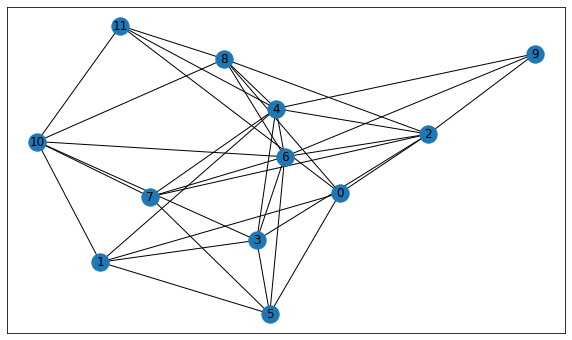



The basic idea is to incorporate the cost function of the problem into a model hamiltonian which time evolves our system into a final state. This final state is then measured onto the computational basis, thereby, returning a string. We repeat this several times, essentially, sampling basis states based on their probability distribution, which in turn, depends on their respective amplitudes in the final state.

Using these sampled results, we calculate the Maxcut cost for each sample and average over them which gives us an estimate of the expectation value of the Maxcut cost for the entire graph w.r.t the final state $\langle\gamma,\beta|C^*|\gamma,\beta\rangle$

## Index

1) [Problem Statement](#introduction)


2) [The Quantum Perspective](#QAOA)


3) [Graph Creation](#graph)


4) [Naïve Classical](#classical)


5) [Quantum Implementation](#quantum)


6) [Results](#results)


7) [References](#papers)

## Problem Statement  <a name='introduction'></a>

The problem of MaxCut can be stated in simple words as follows: We have a set of vertices and edges in a graph G. We need to assign the vertices in either set'0' or set'1' such that the maximum number of edges of G are between vertices of different sets.

Following this description, it can then be easily understood that our final solution should look like a binary string containing the set preference for each vertex. For example, $|011010011\rangle$ may represent a candidate solution for a graph with 9 nodes where nodes:{1,4,6,7} belong to set'0' and nodes:{2,3,5,8,9}belong to set'1'.

Since the problem is NP-hard, the solution time scaling is exponential in the graph size. Therefore, we need better algorithms that do not scale exponentially with the graph size. Maxcut belongs to set of APX-hard problems and we already have a classical approximate algorithm that works quite well but, in this notebook, we just focus on the QAOA's performance on the MaxCut.

## The Quantum Perspective <a name='QAOA'></a>

Let's talk about QAOA and how it can be used to solve the MaxCut.
QAOA was originally proposed by E.Farhi et al.[${[1]}$](#Farhi) in 2014 as an optimization algorithm that can be applied to solve some of the optimization problems, the two most popular ones being, E3Lin2 and MaxCut. We will just focus on Maxcut here.

The first step is to figure out a way to incorporate the cost function of the problem to form a Hamiltonian for our system of qubits.
The idea is to maximize the number of such edges where the corresponding nodes belong to different sets. In terms of bit representation of our nodes we can basically $XOR$ the nodes belonging to a given edge. Then, the motive of the problem is to maximize the sum of these $XOR$'s over the set of edges.

$$\Sigma_{\langle e\rangle}C_{e}$$

Here, $\langle e\rangle$ is the set of all edges and $C_e$ is the cost of that edge which is zero if nodes are in the same set and one if in different sets.
To formulate the same cost function as a hamiltonian, we can write it as follows:

$$H_c = \frac{1}{2}(\mathbb{1}- \sigma_z^{i}\sigma_z^{j})$$

Following this, our state evolving Unitary $U(\gamma)_c$ becomes:

$$U(\gamma)_c = e^{-i\gamma H_c}$$

Alternate application of a mixing hamiltonian $H_b$ along with $H_c$ is performed to render the final circuit as:

$$|\gamma,\beta\rangle_1 = U(\beta)_bU(\gamma)_c|+\rangle$$

This application of $U_b$ together with $U_c$ forms one block of the total operation. We apply 'p' such blocks in the circuit with to obtain better approximate results, the higher the 'p' is. The state $|+\rangle$ is the superposition of all basis states for 'n' qubits, formed by applying Hadamard gate to every qubit.

$$|\gamma,\beta\rangle_p = U(\beta_p)U(\gamma_p)...U(\beta_2)U(\gamma_2)U(\beta_1)U(\gamma_1)|+\rangle$$

The goal of the circuit is to drive the system into a quantum state which, upon measuring in the computational basis, yields with high probability a classical bit string that is approximately close to the optimal string.[${[4]}$](#Wang)


The following part of this notebook contains my implementation of this algorithm to obtain approximate results for MaxCut on a graph with 12 nodes. The solutions contain lists of optimum $\gamma$s and $\beta$s with size 'p' each and contains Cost approximation ratio w.r.t to $C_{max}$ for each p. $C_{max}$ is the best possible solution (calculated classically) 

### Example circuit for 4 nodes and 4 edges

* A $U_c^{01}$ gate for edge between qubit 0 and 1:
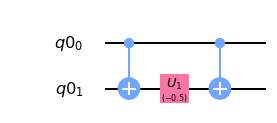

* A sample quantum circuit for a simple ring graph with 4 nodes and 4 edges for p=1: 
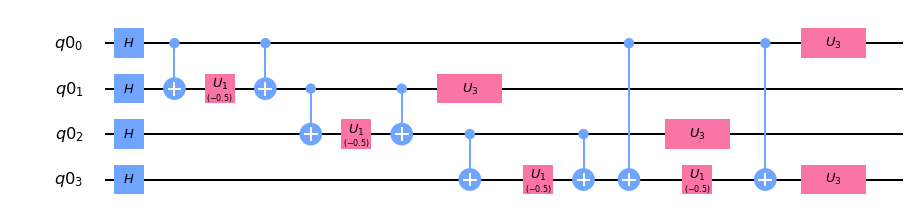

To generalise for higher p this same block repeats with different $\gamma,\beta$ values

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx 
from networkx.generators.random_graphs import erdos_renyi_graph as erg # to generate random Erdos-Renyi Graph
from qiskit import *
from qiskit.tools.visualization import plot_histogram
import time # to time the circuit execution
from numpy import unravel_index

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.figsize'] = 10,6

### Declaring the backend to be the QASM Simulator. 
I will be using the local machine based Quantum Simulator present in qiskit.Aer

In [3]:
backend=Aer.get_backend('qasm_simulator')

## Graph Creation <a name='graph'></a>

### Creating a random graph with 12 nodes 
Here I use the networkx package within python to implement a random graph. I use the erdos-renyi graph generator with a default of 12 nodes and with edge probability of 0.4.
Reader can obviously, change these values and experiment with a different graph. 

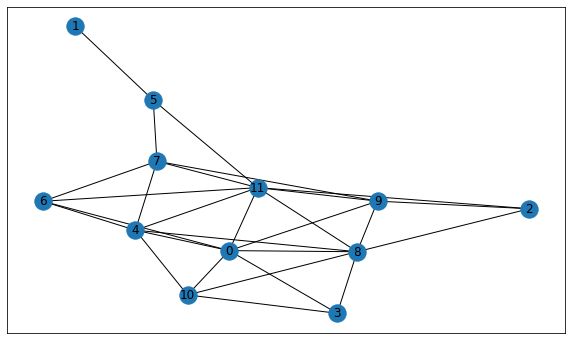

In [4]:
nodes = 12
edge_prob = 0.4
rand_g = erg(nodes, edge_prob)  #create a random erdos-renyi graph
nx.draw_networkx(rand_g)
plt.show()
edges = list(rand_g.edges) #stores the edges as a list of tuples of vertices

## Naive Classical <a name='classical'></a>

The implementation below is the naive way of calculating the best possible string corresponding to the graph above, it is exponential in number of nodes(inefficient). But I use $C_{max}$ obtained here to calculate the approximation ratio later for QAOA results. 

In [5]:
def basisList(nodes):
    """
    Function basisList takes input the number of nodes in the graph 
    and creates all possible strings of vertex divisions in the graph, 
    i.e. it outputs a list of binary strings that is exponential in nodes.
    """
    basisList = np.zeros((2**nodes,nodes),dtype=int)
    for i in range(2**nodes):
        binary = bin(i)[2:].zfill(nodes)
        for j in range(nodes):
            basisList[i][j] = int(binary[j])
    return basisList

def ClassicalObj(nodes,edges):
    """
    Function ClassicalObj calculates the cost function value for each of these strings,one at a time,
    stores and later outputs a list of costs each corresponding to a binary string
    """
    basislist = basisList(nodes)
    costList = np.zeros(2**nodes)
    for i in range(2**nodes):
        basis = basislist[i]
        for k in range(len(edges)):
            l,m = edges[k]
            costList[i] += basis[l]^basis[m]
    return costList

In [6]:
"""
Once, the computation is over, I retrieve the max cost value and the corresponding binary string
as follows for comparison with the quantum version later. 

Note: Since this function is exponential in nodes, it may still be fast for my case with 12 nodes but,
soon becomes super tedious for example 20 nodes.
"""
t1=time.time()
costFuncClassical = ClassicalObj(nodes,edges)
x=np.argmax(costFuncClassical) # index with max cost function value

Cmax = costFuncClassical[x]      # max cost function value
opt_string = basisList(nodes)[x] # optimal string for the graph instance 

print('C_max =',Cmax,'|','Optimal String =',opt_string)
t2=time.time()
print('Execution Time:'"%.2f"%(t2-t1),'seconds')

C_max = 20.0 | Optimal String = [0 0 0 1 1 1 1 0 1 1 0 0]
Execution Time:0.21 seconds


## Quantum Implementation <a name='quantum'></a>

### The following part of the notebook contains the main code.

Since the advent of QAOA(2014) there has been really interesting research to devise better techniques implementing the outer loop classical parameter optimization. It was suggested by E.Farhi et al.[${[1]}$](#Farhi) that we could put a fine grid on the compact set $[0,2\pi]^p,[0,\pi]^p$ and implement circuits on this grid and search for optimum parameters by brute force. As the complexity of this approach quickly grows with increasing 'p'.
There have been alternate approaches to improve upon this.

* Zhou et al.[${[2]}$](#Zhou) suggested a technique called FOURIER which discrete fourier transforms $(\gamma_{i},\beta_{i})$ into set of $(u_k,v_k)$ with 2q parameters instead of 2p. They made the observation that for different p, the parameters varied rather smoothly, thereby eliminating the need of high frequency components in the fourier transform of $(\gamma_{i},\beta_{i})$. This made the problem fixed in q, for a p increasing with n. Their paper also claims much better performance using FOURIER method as it performs better in the higher 'p' regime, where brute-force starts saturating.

* Wang et al.[${[4]}$](#Wang) derived an analytical formula in $\gamma,\beta$  for calculating the expectation value. This allowed direct maximization of the formula returning optimum $\gamma_{*},\beta_{*}$ eliminating the need to search by brute-force over the entire grid. But this approach soon becomes tedious as p increases.

* Another paper by Streif et al.[${[3]}$](#Streif) tries to eliminate the need for repeated access to the QPU by inferring from the observations that the average value of these parameters only depended on the topology of the graph and the fact that they can be reused for other similar graph instances. Although, this is not entirely a new idea as Farhi et al.[$[1]$](#Farhi) had already proposed the fundamental idea of this reverse causal cone.

Personally, I liked the approach taken in [$[3]$](#Streif) as in my experience repeated QPU access is the most time consuming step of the evaluation and I would like to cut down on it as much as possible. Although, all these papers make excellent observations they still implemented these techniques on very specific graphs, for e.g. rings or d-regular graphs. Generalizing any of these techniques for a random graph did not appear so trivial to me and seemed beyond the scope of this exercise. Therefore, in this notebook, I stick to the original grid based method.

I have tried making it a bit more efficient though with the following ideas:
* Instead of a fine grid on the set $[0,2\pi]^p,[0,\pi]^p$, I use p-repeated executions on a coarse grid on the set $[0,\pi],[0,\pi]$ optimizing for level p-1 and using those values while optimizing for level p.
* On the coarser set I optimize for $(\gamma,\beta)$ and then make another finer grid centred around the obtained $(\gamma,\beta)$ to obtain more precise values. This improves a bit upon the time complexity of brute-search.
* For a given p, I first optimize for p=1, save the optimum parameters, then proceed to p=2 and repeat until p=p iteratively. Thus, my optimization requires O($p\times$gridSize) computations instead of O(gridSize$^p$).
* Since $H_c$ is real-valued, hence it has time-reversal like symmtery[${[2]}$](#Zhou), I use $\gamma$ in range $[0,\pi]$ instead of $[0,2\pi]$.

### The basic structure of my implementation is as follows: 

* First define the unitaries for the quantum circuit.

* Second, I define the cost function as 'objective' which implements the quantum circuit with input parameters -> executes it -> calculates the cost for each of the measurement results -> computes their average and returns the thus obtained expectation value for the given parameters.

* Third, the 'gridEval' function computes the costFunction for each pair of $(\gamma,\beta)$ on the grid and array containing expectation estimates for each pair.

* Fourth, function 'param_opt' searches for the highest expectation value estimate and retrieves the corresponding $(\gamma^{*},\beta^{*})$ and appends that to the input List of $(\gamma,\beta)$ that goes into the 'objective' function. This happens iteratively for 'p' and returns the lists of 2p optimum $\gamma$s and $\beta$s and the list cost function value after each iteration. We can use this list to check the performance improvement after each p. We expect to obtain an increasing curve.

### Functions Implementing the Unitaries $U_c(\gamma)$ and $U_b(\beta)$

In [7]:
def Ub(beta,ckt,qreg):
    '''
    Applies the U3 gate(rotation about the x-axis) on all the qubits in the register
    '''
    ckt.u3(2*beta,-np.pi/2,np.pi/2,qreg);

def Uc(gamma,ckt,qreg):
    '''
    For each edge, applies CNOT-U1-CNOT sequence. This unitary can be decomposed into
    the fundamental CNOT-U1-CNOT sequence.
    '''
    for k in range(len(edges)):
        i,j = edges[k]
        ckt.cx(qreg[i],qreg[j])
        ckt.u1(-gamma,qreg[j])
        ckt.cx(qreg[i],qreg[j])

### Objective/Cost Function:

It takes as input a list of $\gamma$'s, a list of $\beta$'s, list of edges, number of nodes and the backend. Using these arguments it first creates the quantum circuit based on the given graph. Then it executes the circuit on the provided backend. Since, my circuit does not contain redundancy and comprises only of fundamental gates, I will use the optimization_level=0 for this execution. This saves some time during the circuit transpiling and assembling. The execution command will perform projective measurement, returning a basis state each time. We sample these measurement results 'num_shots' times. 
The values thus obtained are used to calculate the estimate expectation value of the current circuit.


Worth noting here is the fact that function executes one circuit at a time on the backend. Since qiskit executes circuits asynchronously, it is ideal to first create a list of circuits for all pairs of $\gamma,\beta$ and then execute that circuit list in parallel to save the overhead of waiting in the queue everytime. But, based on my experimentation the difference in performance between these two implementations is rather negligible for the local machine based qiskit.Aer simulator. As I am using aer simulator for this notebook, I will stick to the single circuit execution. Implementing, the circuit list based execution is quite straightforward. The list based parallel implementation is hands down 'the' choice is to use when accessing cloud based backend provided directly by IBM.

In [8]:
def objective(gamma,beta,edges=edges,qubits=nodes,backend=backend,num_shots=1000):
    """
    Simulates noiseless quantum state generation using qiskit.aer, then samples the 
    measurement result num_shots times, calculates and returns the <expectation> value estimate 
    """
    #Create the Quantum Circuit    
    qreg = QuantumRegister(qubits)
    creg = ClassicalRegister(qubits)
    ckt = (QuantumCircuit(qreg,creg))
    ckt.h(qreg)    # state |+> is created
    for k in range(len(gamma)): # for the leve p=k this part applies upto 2*(k-1) optimized gamma,beta 
        Uc(gamma[k],ckt,qreg)   # from the previous levels while doing grid search for parameters for 
        Ub(beta[k],ckt,qreg)    # level k. In other words, at a given time, gamma and beta are lists that 
    ckt.measure(qreg,creg)      # contain optimized values until level 'k-1' and trial values at level 'k' 
    #Execute the circuit and extract the results    
    job_result = execute(ckt,backend,shots=num_shots,meas_return='single',optimization_level=0).result()
    counts = job_result.get_counts()
    #list 'samples' now contains the measurement outcome along with their frequency   
    samples = list(counts.items())
    #Use samples data to calculate the expectation value estimate. 
    #*Note*: Since, qiskit represents qubit 0 as the leading one in 
    #the string, we will have to reverse the binary list to maintain consistency.
    cost=0
    for sample in samples:
        i,j = sample
        i=[int(list(i)[k]) for k in range(len(list(i)))]  #purpose: string '11001' goes to [1,1,0,0,1]
        i.reverse()                  # list reversal to make qubit-0 as the trailing bit
        j=j/num_shots                # j represents the frequency of the bit 'i' 
        xor_bit=0
        for b in range(len(edges)):
            l,m = edges[b]
            xor_bit += i[l]^i[m]     # bitwise XOR between edges to compute MaxCut Objective
        cost += xor_bit*j            # cost value for bit 'i' multiplied by its frequency
    return cost

### Function: Grid Evaluation

In [9]:
def gridEval(gammaInput,betaInput,gammaIter,betaIter,block,gridFinesse):
    """
    Computes the costFunction for each pair of (gamma,beta) on the grid 
    and array containing expectation estimates for each pair.
    """   
    t1=time.time()
    # expectation[i][j] will store cost value for circuit with parameter gammaIter[i],betaIter[j]
    # where gammaIter,betaIter form the grid for brute-force optimization
    expectation = np.empty((gridFinesse,gridFinesse))
    for i,gamma in enumerate(gammaIter):
        gammaInput[block]=gamma
        for j,beta in enumerate(betaIter):
            betaInput[block]=beta
            expectation[i][j] = objective(gammaInput,betaInput)
    #unpack index returning optimum cost function value    
    g_i,b_j = unravel_index(np.argmax(expectation),np.shape(expectation))
    # gammaIter[g_i],betaIter[b_j] are the optimum parameter from layer-1 
    # using these optima, I form the grid for layer-2 brute-force search around these values
    
    gammaStar = gammaIter[g_i]
    betaStar = betaIter[b_j]
    # radius defines the size of grid for layer-2 which is centred around gammaStar,betaStar
    radius = np.pi/(gridFinesse) 
    
    g_start = gammaStar-radius
    g_end = gammaStar+radius
    b_start = betaStar-radius
    b_end = betaStar+radius

    if(g_start<0):
        g_start=0
    if(b_start<0):
        b_start=0
    if(g_end>np.pi):
        g_end=np.pi
    if(b_end>np.pi):
        b_start=np.pi   

    gammaIter2 = np.linspace(g_start,g_end,gridFinesse)
    betaIter2 = np.linspace(b_start,b_end,gridFinesse)
    # repeat similar execution for pairs of (gamma,beta) and store 
    for i,gamma2 in enumerate(gammaIter2):
        gammaInput[block]=gamma2
        for j,beta2 in enumerate(betaIter2):
            betaInput[block]=beta2
            expectation[i][j] = objective(gammaInput,betaInput)
    #unpack index returning optimum cost function value after layer-2 optimization
    g_i,b_j = unravel_index(np.argmax(expectation),np.shape(expectation))
    
    gammaFinal = gammaIter2[g_i]
    betaFinal = betaIter2[b_j]
    values = [expectation,gammaFinal,betaFinal]
    t2=time.time()
    print("Execution time for p=%d:"%block+1,"%.2f"%(t2-t1),'seconds')
    return values

### Function: Parameter Optimization

In [10]:
def param_opt(p,gridSize=5,qubits=nodes,edges=edges):
    """
    Calls 'gridEval' p times and returns cost value list for all iterations upto p
    and their respective optimum parameters #p gammas and #p betas
    """
    t1=time.time()    
    gridFinesse=gridSize
    # Stores the grid of gamma, beta values for 
    gammaIter = np.linspace(0,np.pi,gridFinesse) 
    betaIter = np.linspace(0,np.pi,gridFinesse)
    # For kth iteration in 'p' loop, it stores optimized parameters 
    # until level k-1 and to be optimized parameter for level-k.
    # The list starts with size=1 (for p=1) and grows upto size='p' upon loop termination
    gammaInput=[]
    betaInput=[]
    # cStar stores a list of optimum cost value corresponding to 2k optimum parameters
    # first element for p=1, second for p=2 and so on until the last element for p=p
    cStar = np.empty(p)

    # this loops iteratively calls the evaluation function stores the optimum values of cost and
    # parameters provided by function 'gridEval', unpacks and appends these values respectively 
    # to cStar, gammaInput and betaInput lists.
    for blk in range(p):
        gammaInput.append(0)
        betaInput.append(0)
        evals = gridEval(gammaInput,betaInput,gammaIter,betaIter,blk,gridFinesse)
        # exp stores the max cost function for the optimum gamma,beta on the grid
        cStar[blk] = np.max(evals[0])
        print('Expectation estimate for p =',blk+1,':',"%.3f"%cStar[blk])
        #set the optimum gamma,beta for level-blk as optima obtained from the output of gridEval
        [gammaInput[blk],betaInput[blk]] = [evals[1],evals[2]]
        print("%.4f"%gammaInput[blk],',',"%.4f"%betaInput[blk])
        print('block:',blk+1,'complete','\n','.....................................................')                
    t2=time.time()
    print('Total time:',"%.2f"%(t2-t1))
    outputs = [gammaInput,betaInput,cStar]
    return outputs

## Results <a name='results'></a>

In this section, I use all the functions defined above to calculate the expectation value estimates for different p's.
I, further, compare their performance and show how solution quality improves as p increases.

In [11]:
output = param_opt(gridSize=10,p=10)

Execution time for p=0: 23.83 seconds
Expectation estimate for p = 1 : 16.668
0.3840 , 0.3142
block: 1 complete 
 .....................................................
Execution time for p=1: 37.39 seconds
Expectation estimate for p = 2 : 17.525
0.7330 , 1.7802
block: 2 complete 
 .....................................................
Execution time for p=2: 46.58 seconds
Expectation estimate for p = 3 : 17.928
0.7330 , 1.7802
block: 3 complete 
 .....................................................
Execution time for p=3: 61.97 seconds
Expectation estimate for p = 4 : 18.136
0.8727 , 1.7104
block: 4 complete 
 .....................................................
Execution time for p=4: 76.94 seconds
Expectation estimate for p = 5 : 18.133
0.7330 , 3.2114
block: 5 complete 
 .....................................................
Execution time for p=5: 92.07 seconds
Expectation estimate for p = 6 : 18.196
0.2094 , 0.0000
block: 6 complete 
 ..............................................

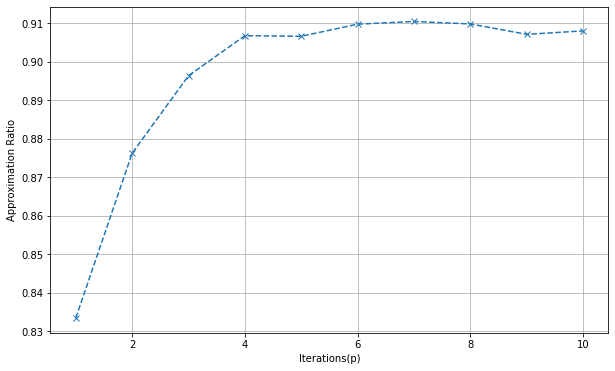

In [16]:
opt_gammas = output[0] #optimum list of p gammas
opt_betas = output[1]  #optimum list of p betas
cStar = output[2]
appRatio = cStar/Cmax # Approximate quality of cost values (obtained by dividing by C_max)
x = [i+1 for i in range(len(cStar))]
plt.plot(x,appRatio,marker='x',ls='--')
plt.grid(True)
plt.xlabel('Iterations(p)');
plt.ylabel('Approximation Ratio');

### Some observations on the Results

* We see that approximation ratio increases with increasing p, which is an expected behaviour, since the maximization at p − 1 can be viewed as a constrained maximization at p (E.Farhi et al.[${[1]}$](#Farhi)), i.e,
$$M_p \geq M_{p-1}$$

* We can also note, that for increasing p, the rate of increment in performance decreases. In other words, the ratio values soon start saturating. 

* Upon executing the optimization process in Cell-11, you will notice that optimization runs faster for smaller p than larger. This is an expected behaviour, since, the depth of circuit increases with increasing p, and hence, so does the execution time.

* By default, I run it for gridFinesse=10, which means my parameters take 10 discrete values between $[0,\pi]$, find an optima on this grid. Make another grid of same size around this optima and run the optimization again to obtain more precise parameters. Based on my experimentation, it provides, as good results, as for higher Finesse of parameter set discretization but, is computationally more efficient. 

* As a default, I have also specified p=10 and with these current arguments the process takes on average ~10 minutes to run on my system. If you compare this with the fraction of a second taken by the Naive exponential algorithm, it does not seem too flattering. However, as soon as you increase your system size, let's say, for e.g. with 20 nodes, the QAOA starts giving a tough fight for lower 'p' values. This is a result of QAOA not scaling exponentially with the problem size.

* As I did mention before, brute-force parameter optimization is not the ideal way to implement this and it will be really interesting to research about better techniques providing better results in lesser time. 

* We also see fluctuations for higher values of 'p'. These can perhaps, be attributed to the fact, that we are sampling a fixed number of times from the probability distribution of $2^{nodes}$ basis states. Since, performance increment is small for higher 'p', it may sometimes lead to a smaller value than the one for p-1.

## References <a name='papers'></a>

1) E. Farhi, J. Goldstone, S. Gutmann, A Quantum Approximate Optimization Algorithm (2014) (available at http://arxiv.org/abs/1411.4028). <a name='Farhi'></a>

2) L. Zhou, S.-T. Wang, S. Choi, H. Pichler, M. D. Lukin, Quantum Approximate Optimization Algorithm: Performance, Mechanism, and Implementation on Near-Term Devices (2018) (available at http://arxiv.org/abs/1812.01041). <a name='Zhou'></a>

3) M. Streif, M. Leib, Training the Quantum Approximate Optimization Algorithm without access to a Quantum Processing Unit (2019) (available at http://arxiv.org/abs/1908.08862). <a name='Streif'></a>

4) Z. Wang, S. Hadfield, Z. Jiang, E. G. Rieffel, Quantum approximate optimization algorithm for MaxCut: A fermionic view. Physical Review A. 97 (2018), doi:10.1103/PhysRevA.97.022304. <a name='Wang'></a>